In [1]:
import json
import os
import csv
import gc
import urllib
from io import BytesIO
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0")

In [2]:
PATH_TO_DATA = 'D:/Py/DataFrames/dlcourse_ai/HotDogOrNot'

In [3]:
train_folder = os.path.join(PATH_TO_DATA, "train/")
print('Number of files in the train folder', len(os.listdir(train_folder)))

test_folder = os.path.join(PATH_TO_DATA, "test/")
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


## Helpers

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None, use_albumentations=False):
        self.transform = transform
        self.use_albumentations = use_albumentations
        self.root_dir = folder
        self.data = os.listdir(folder)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_id = self.data[index]
        img = Image.open(os.path.join(self.root_dir, img_id))
            
        if self.transform:
            if self.use_albumentations:
                image = self.transform(image=np.array(img))
                img = image['image']
            else:
                img = self.transform(img)
        
        if 'frankfurter' in img_id or 'chili-dog' in img_id or 'hotdog' in img_id:
            y = 1
        else:
            y = 0
        
        return img, y, img_id

In [5]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [6]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')

In [7]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    
    correct_samples = 0
    total_samples = 0
    
    for (x, y,_) in loader:
        x_gpu, y_gpu = x.to(device), y.to(device)
        prediction = model(x_gpu)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
    accuracy = float(correct_samples) / total_samples
    
    return accuracy

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler=None, num_epochs=10):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if scheduler:
            scheduler.step()
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    del x_gpu, y_gpu, prediction
    gc.collect()
        
    return loss_history, train_history, val_history

In [9]:
def evaluate_model(model, dataset, indices, batch_size=64):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval()
    
    predictions = []
    ground_truth = []
    subset_sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=subset_sampler)
    
    for (x,y,_) in loader:
        x_gpu = x.to(device)
        prediction = model(x_gpu)
        
        predictions.extend(prediction.tolist())
        ground_truth.extend(y.tolist())
        
        del x_gpu, prediction
        
    return np.array(predictions), np.array(ground_truth)

In [10]:
import sklearn.metrics as metrics
def binary_classification_metrics(predictions, ground_truth):
    assert len(predictions) == len(ground_truth)
    
    tp = np.sum((predictions==ground_truth) & (predictions==True))
    fp = np.sum((predictions!=ground_truth) & (predictions==True))
    fn = np.sum((predictions!=ground_truth) & (predictions==False))
    
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    
    return precision, recall, f1

In [11]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}

In [12]:
def submit(best_model, best_model_name='', filename='test_submit.csv'):
    best_model.eval()
    
    image_id = []
    predictions = []

    for x,_,id_img in test_loader:
        x_gpu = x.to(device)
        prediction = torch.argmax(model(x_gpu), 1)
        predictions.extend(prediction.tolist())
        image_id.extend(id_img)
        
    with open(filename, 'w') as submissionFile:
        writer = csv.writer(submissionFile)
        writer.writerow(['image_id', 'label'])
        writer.writerows(zip(image_id,predictions))
        
    print('Model: {}'.format(best_model_name))
    print('Submit filename: {}'.format(filename))

In [13]:
def save_all(model_name):
    torch.cuda.empty_cache()
    model.eval()
    test_predictions = []

    for x,_,id_img in test_loader:
        x_gpu = x.to(device)
        prediction = model(x_gpu)
        test_predictions.extend(prediction.tolist())
        
        del x_gpu, prediction
    
    test_predictions = np.array(test_predictions)
    
    np.save('{}_train_preds.npy'.format(model_name), predictions[:, 0])
    np.save('{}_test_preds.npy'.format(model_name), test_predictions[:, 0])
    torch.save(model.state_dict(), os.path.join(PATH_TO_DATA, '{}_model.pkl'.format(model_name)))
    submit(model, model_name, '{}_submit.csv'.format(model_name))

In [14]:
def prepare_data(train_dataset, test_dataset,
                 validation_fraction=0.2, batch_size=64):
    data_size = len(train_dataset)
    val_split = int(np.floor((validation_fraction) * data_size))
    indices = list(range(data_size))
    np.random.seed(42)
    np.random.shuffle(indices)

    train_indices, val_indices = indices[val_split:], indices[:val_split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=int(batch_size/2),
                                             sampler=val_sampler)
    # Notice that we create test data loader in a different way. We don't have the labels.
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader, val_indices

---

In [16]:
import albumentations
from albumentations import torch as AT

tfs_for_vis = albumentations.Compose([
    albumentations.RandomRotate90(p=0.3),
    albumentations.Blur(p=0.1),
    albumentations.RandomBrightness(p=0.3),
    albumentations.GaussNoise(p=0.3),
    albumentations.ShiftScaleRotate(p=0.3),
    albumentations.JpegCompression(quality_lower=90, p=0.3),
])

albu_tfs = albumentations.Compose([
    albumentations.RandomRotate90(p=0.3),
    albumentations.Blur(p=0.1),
    albumentations.RandomBrightness(p=0.3),
    albumentations.GaussNoise(p=0.3),
    albumentations.ShiftScaleRotate(p=0.3),
    albumentations.JpegCompression(quality_lower=90, p=0.3),
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    AT.ToTensor(),
])

In [16]:
train_dataset = HotdogOrNotDataset(train_folder, transform=albu_tfs, use_albumentations=True)
test_dataset = HotdogOrNotDataset(test_folder, transform=albu_tfs, use_albumentations=True)
train_loader, val_loader, test_loader, val_indices = prepare_data(train_dataset, test_dataset)

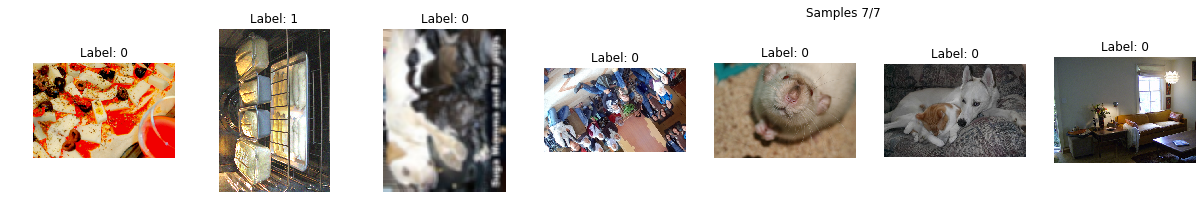

In [17]:
train_vis_dataset = HotdogOrNotDataset(train_folder, transform=tfs_for_vis, use_albumentations=True)
indices = np.random.choice(np.arange(len(train_vis_dataset)), 7, replace=False)

visualize_samples(train_vis_dataset, indices, "Samples")

In [21]:
%%time

torch.cuda.empty_cache()
model = models.resnet50(pretrained=True)
for l in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2]:
    for param in l.parameters():
        param.requires_grad = False

resnet_output = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(resnet_output, 512, bias=False),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Softmax(dim=-1)
)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=1e-3, momentum=0.9, weight_decay=1e-2)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader,
                                                       loss, optimizer, num_epochs=10)

Average loss: 0.533028, Train accuracy: 0.859354, Val accuracy: 0.933696
Average loss: 0.427620, Train accuracy: 0.931849, Val accuracy: 0.947826
Average loss: 0.399691, Train accuracy: 0.943796, Val accuracy: 0.951087
Average loss: 0.384835, Train accuracy: 0.953027, Val accuracy: 0.958696
Average loss: 0.375588, Train accuracy: 0.959001, Val accuracy: 0.958696
Average loss: 0.371418, Train accuracy: 0.961444, Val accuracy: 0.955435
Average loss: 0.365085, Train accuracy: 0.964974, Val accuracy: 0.959783
Average loss: 0.362131, Train accuracy: 0.966060, Val accuracy: 0.960870
Average loss: 0.359583, Train accuracy: 0.968232, Val accuracy: 0.960870
Average loss: 0.354911, Train accuracy: 0.970948, Val accuracy: 0.965217
Wall time: 25min 28s


In [22]:
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
argmax_predictions = np.argmax(predictions, -1)
precision, recall, f1 = binary_classification_metrics(argmax_predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.951, P: 0.967, R: 0.936


In [19]:
save_all('resnet50')

Model: resnet50
Submit filename: resnet50_submit.csv


In [23]:
%%time

torch.cuda.empty_cache()
model = models.vgg11_bn(pretrained=True)
for l in [model.features, model.classifier[0], model.classifier[1], model.classifier[2]]:
    for param in l.parameters():
        param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(1000, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Softmax(dim=-1)
)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=1e-3, momentum=0.9, weight_decay=1e-2)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader,
                                                       loss, optimizer, num_epochs=10)

Average loss: 2.826731, Train accuracy: 0.591909, Val accuracy: 0.883696
Average loss: 0.285275, Train accuracy: 0.896823, Val accuracy: 0.914130
Average loss: 0.229937, Train accuracy: 0.912843, Val accuracy: 0.915217
Average loss: 0.208842, Train accuracy: 0.920988, Val accuracy: 0.928261
Average loss: 0.194908, Train accuracy: 0.924518, Val accuracy: 0.919565
Average loss: 0.185657, Train accuracy: 0.928048, Val accuracy: 0.933696
Average loss: 0.179321, Train accuracy: 0.931034, Val accuracy: 0.940217
Average loss: 0.177338, Train accuracy: 0.930763, Val accuracy: 0.940217
Average loss: 0.175007, Train accuracy: 0.932935, Val accuracy: 0.943478
Average loss: 0.161993, Train accuracy: 0.934564, Val accuracy: 0.947826
Wall time: 20min 29s


In [24]:
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
argmax_predictions = np.argmax(predictions, -1)
precision, recall, f1 = binary_classification_metrics(argmax_predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.911, P: 0.900, R: 0.923


In [25]:
save_all('vgg_11bn')

Model: vgg_11bn
Submit filename: vgg_11bn_submit.csv


In [17]:
albu_tfs = albumentations.Compose([
    albumentations.RandomRotate90(),
    albumentations.HorizontalFlip(),
    albumentations.ShiftScaleRotate(),
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    AT.ToTensor(),
])

train_dataset = HotdogOrNotDataset(train_folder, transform=albu_tfs, use_albumentations=True)
test_dataset = HotdogOrNotDataset(test_folder, transform=albu_tfs, use_albumentations=True)
train_loader, val_loader, test_loader, val_indices = prepare_data(train_dataset, test_dataset)

In [18]:
%%time
# only flips and rotations
torch.cuda.empty_cache()
model = models.vgg16(pretrained=True)
for l in [model.features, model.avgpool, model.classifier[0]]:
    for param in l.parameters():
        param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(1000, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Softmax(dim=-1)
)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr=3e-4, weight_decay=1e-2)
#step_lr = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader,
                                                       loss, optimizer, num_epochs=10)

Average loss: 1.107940, Train accuracy: 0.832474, Val accuracy: 0.940217
Average loss: 0.181333, Train accuracy: 0.939452, Val accuracy: 0.941304
Average loss: 0.175571, Train accuracy: 0.936736, Val accuracy: 0.943478
Average loss: 0.167634, Train accuracy: 0.934293, Val accuracy: 0.946739
Average loss: 0.146533, Train accuracy: 0.945696, Val accuracy: 0.936957
Average loss: 0.153089, Train accuracy: 0.938094, Val accuracy: 0.944565
Average loss: 0.145630, Train accuracy: 0.946783, Val accuracy: 0.951087
Average loss: 0.140802, Train accuracy: 0.948140, Val accuracy: 0.942391
Average loss: 0.140167, Train accuracy: 0.945696, Val accuracy: 0.944565
Average loss: 0.138120, Train accuracy: 0.946239, Val accuracy: 0.956522
Wall time: 11min 32s


In [19]:
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
argmax_predictions = np.argmax(predictions, -1)
precision, recall, f1 = binary_classification_metrics(argmax_predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.921, P: 0.946, R: 0.897


In [20]:
save_all('vgg_16')

Model: vgg_16
Submit filename: vgg_16_submit.csv


In [25]:
%%time
# only flips and rotations
torch.cuda.empty_cache()
model = models.resnet34(pretrained=True)
for l in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2]:
    for param in l.parameters():
        param.requires_grad = False

resnet_output = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(resnet_output, 256, bias=False),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.Softmax(dim=-1)
)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=1e-3, momentum=0.9, weight_decay=1e-2)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader,
                                                       loss, optimizer, num_epochs=10)

Average loss: 0.624355, Train accuracy: 0.725767, Val accuracy: 0.848913
Average loss: 0.506982, Train accuracy: 0.882433, Val accuracy: 0.909783
Average loss: 0.457245, Train accuracy: 0.917459, Val accuracy: 0.927174
Average loss: 0.430142, Train accuracy: 0.931306, Val accuracy: 0.943478
Average loss: 0.415831, Train accuracy: 0.934021, Val accuracy: 0.935870
Average loss: 0.400870, Train accuracy: 0.947597, Val accuracy: 0.943478
Average loss: 0.393186, Train accuracy: 0.948140, Val accuracy: 0.943478
Average loss: 0.387090, Train accuracy: 0.953842, Val accuracy: 0.951087
Average loss: 0.386201, Train accuracy: 0.949226, Val accuracy: 0.954348
Average loss: 0.378910, Train accuracy: 0.956286, Val accuracy: 0.950000
Wall time: 9min 46s


In [26]:
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
argmax_predictions = np.argmax(predictions, -1)
precision, recall, f1 = binary_classification_metrics(argmax_predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.930, P: 0.924, R: 0.936


In [27]:
save_all('resnet34')

Model: resnet34
Submit filename: resnet34_submit.csv


In [32]:
import albumentations
from albumentations import torch as AT

albu_tfs = albumentations.Compose([
    albumentations.RandomRotate90(),
    albumentations.HorizontalFlip(),
    albumentations.GaussNoise(),
    albumentations.RGBShift(),
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    AT.ToTensor(),
])

train_dataset = HotdogOrNotDataset(train_folder, transform=albu_tfs, use_albumentations=True)
test_dataset = HotdogOrNotDataset(test_folder, transform=albu_tfs, use_albumentations=True)
train_loader, val_loader, test_loader, val_indices = prepare_data(train_dataset, test_dataset)

In [34]:
%%time
# flips, rotations, noise and rgbshift
torch.cuda.empty_cache()
model = models.resnet101(pretrained=True)
for l in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3]:
    for param in l.parameters():
        param.requires_grad = False

resnet_output = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(resnet_output, 512, bias=False),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Softmax(dim=-1)
)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=1e-3, momentum=0.9, weight_decay=1e-2)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader,
                                                       loss, optimizer, num_epochs=10)

Average loss: 0.542038, Train accuracy: 0.856367, Val accuracy: 0.909783
Average loss: 0.425814, Train accuracy: 0.930763, Val accuracy: 0.943478
Average loss: 0.398974, Train accuracy: 0.948412, Val accuracy: 0.948913
Average loss: 0.387320, Train accuracy: 0.950312, Val accuracy: 0.946739
Average loss: 0.381465, Train accuracy: 0.950041, Val accuracy: 0.953261
Average loss: 0.371823, Train accuracy: 0.960630, Val accuracy: 0.946739
Average loss: 0.370281, Train accuracy: 0.960630, Val accuracy: 0.955435
Average loss: 0.367526, Train accuracy: 0.961716, Val accuracy: 0.955435
Average loss: 0.362575, Train accuracy: 0.966060, Val accuracy: 0.956522
Average loss: 0.363868, Train accuracy: 0.964160, Val accuracy: 0.960870
Wall time: 24min 39s


In [35]:
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
argmax_predictions = np.argmax(predictions, -1)
precision, recall, f1 = binary_classification_metrics(argmax_predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.937, P: 0.936, R: 0.939


In [36]:
save_all('resnet101')

Model: resnet101
Submit filename: resnet101_submit.csv


In [38]:
%%time

torch.cuda.empty_cache()
model = models.densenet121(pretrained=True)
for l in [model.features]:
    for param in l.parameters():
        param.requires_grad = False

densenet_output = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(densenet_output, 512, bias=False),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Softmax(dim=-1)
)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=1e-3, momentum=0.9, weight_decay=1e-2)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader,
                                                       loss, optimizer, num_epochs=10)

Average loss: 0.576176, Train accuracy: 0.816454, Val accuracy: 0.895652
Average loss: 0.479408, Train accuracy: 0.899810, Val accuracy: 0.919565
Average loss: 0.444088, Train accuracy: 0.919631, Val accuracy: 0.926087
Average loss: 0.425103, Train accuracy: 0.929948, Val accuracy: 0.939130
Average loss: 0.416128, Train accuracy: 0.931034, Val accuracy: 0.939130
Average loss: 0.411057, Train accuracy: 0.932121, Val accuracy: 0.941304
Average loss: 0.403032, Train accuracy: 0.935922, Val accuracy: 0.942391
Average loss: 0.398549, Train accuracy: 0.942167, Val accuracy: 0.941304
Average loss: 0.395386, Train accuracy: 0.943524, Val accuracy: 0.946739
Average loss: 0.391657, Train accuracy: 0.944339, Val accuracy: 0.946739
Wall time: 24min 44s


In [39]:
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
argmax_predictions = np.argmax(predictions, -1)
precision, recall, f1 = binary_classification_metrics(argmax_predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.909, P: 0.932, R: 0.887


In [40]:
save_all('densenet121')

Model: densenet121
Submit filename: densenet121_submit.csv


Ensemble

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [92]:
train_preds = []
test_preds = []

models = ['resnet34', 'resnet50', 'resnet101',
          'vgg_11bn', 'vgg_16']
for model_name in models:
    train_preds.append(np.load('{}_train_preds.npy'.format(model_name)))
    test_preds.append(np.load('{}_test_preds.npy'.format(model_name)))
    
train_preds = np.array(train_preds)
test_preds = np.array(test_preds)

train_df = pd.DataFrame(train_preds.T, columns=models)
test_df = pd.DataFrame(test_preds.T, columns=models)

In [98]:
train_index, valid_index = train_test_split(np.arange(len(train_df)), test_size=0.2, random_state=42)
y_train = ground_truth[train_index]
y_valid = ground_truth[valid_index]

train_part = train_df.iloc[train_index]
valid_part = train_df.iloc[valid_index]

dtrain = lgb.Dataset(train_part, label=y_train,
                     feature_name=models)
dvalid = lgb.Dataset(valid_part, label=y_valid,
                     feature_name=models)

In [105]:
rounds = 10000
early_stop_rounds = 25
params = {
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'lambda_l2': 10,
    'learning_rate' : 1e-3,
    'verbosity' : -1
}

In [106]:
%%time
model = lgb.train(params, dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train', 'valid'],
                  num_boost_round=rounds,
                  early_stopping_rounds=early_stop_rounds, 
                  verbose_eval=200)

Training until validation scores don't improve for 25 rounds.
[200]	train's binary_logloss: 0.517071	valid's binary_logloss: 0.499301
[400]	train's binary_logloss: 0.426482	valid's binary_logloss: 0.409621
[600]	train's binary_logloss: 0.358674	valid's binary_logloss: 0.341818
[800]	train's binary_logloss: 0.306861	valid's binary_logloss: 0.289136
[1000]	train's binary_logloss: 0.266536	valid's binary_logloss: 0.248391
[1200]	train's binary_logloss: 0.234769	valid's binary_logloss: 0.216323
[1400]	train's binary_logloss: 0.209397	valid's binary_logloss: 0.190802
[1600]	train's binary_logloss: 0.188986	valid's binary_logloss: 0.170532
[1800]	train's binary_logloss: 0.172433	valid's binary_logloss: 0.154736
[2000]	train's binary_logloss: 0.158911	valid's binary_logloss: 0.141893
[2200]	train's binary_logloss: 0.147785	valid's binary_logloss: 0.13148
[2400]	train's binary_logloss: 0.138541	valid's binary_logloss: 0.12289
[2600]	train's binary_logloss: 0.130825	valid's binary_logloss: 0.11

In [107]:
train_predictions = np.round(model.predict(train_part)).astype(int)
valid_predictions = np.round(model.predict(valid_part)).astype(int)
test_predictions = np.round(model.predict(test_df.values)).astype(int)

precision, recall, f1 = binary_classification_metrics(train_predictions, y_train)
print("[Train part] F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))
precision, recall, f1 = binary_classification_metrics(valid_predictions, y_valid)
print("[Valid part] F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

[Train part] F1: 0.974, P: 0.980, R: 0.968
[Valid part] F1: 0.966, P: 0.966, R: 0.966


### Submit

In [108]:
# PUBLIC score: 0.95652
# PRIVATE score: 0.94639

image_id = []
for x,_,id_img in test_loader:
    image_id.extend(id_img)

with open('lgb_ensemble_with_l2reg.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,test_predictions))